In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.style.use('matplotlibrc.py')

In [2]:
def gradient_image(ax, extent, direction=0.3, cmap_range=(0, 1), **kwargs):
    phi = direction * np.pi / 2
    v = np.array([np.cos(phi), np.sin(phi)])
    X = np.array([[v @ [1, 0], v @ [1, 1]],
                  [v @ [0, 0], v @ [0, 1]]])
    a, b = cmap_range
    X = a + (b - a) / X.max() * X
    im = ax.imshow(X, extent=extent, alpha=0.45, interpolation='bicubic',
                   vmin=0, vmax=1, **kwargs)
    return im

In [3]:
def make_diagram(a_14_days,p_seven):
    fig1, ax1 = plt.subplots()
    ax1.plot(a_14_days, p_seven, 'ko--', fillstyle='none', linewidth=0.5)
    lim = ax1.get_xlim()
    x = np.ones(int(lim[1]))
    ax1.plot(x, 'k-', fillstyle='none', linewidth=0.5)
    ax1.set_ylim(0, 2.5)
    ax1.set_xlim(0, max(a_14_days)+100)
    ax1.set_ylabel(r'$R_{t}^{7}$',fontsize=14)
    ax1.set_xlabel(r'$A_{t}^{14}$',fontsize=14)
    color_map = plt.cm.hsv
    cmap = color_map.reversed()
    for i in a_14_days:
        if i < 30:
            c_min = 0.6
            c_max = 0.89
        elif 30 > i < 100:
            c_min = 0.65
            c_max = 0.95
        elif 100 > i < 200:
            c_min = 0.65
            c_max = 1.1
        else:
            c_min = 0.65
            c_max = 1.3
    gi = gradient_image(ax1, direction=0.6, extent=(0, 1, 0, 1), transform=ax1.transAxes,
                    cmap=cmap, cmap_range=(c_min, c_max))
    #fig1.colorbar(gi, ax=ax1)
    ax1.set_aspect('auto')
    fig1.tight_layout()
    plt.savefig('riesgo_sir_mod0.pdf',bbox_inches='tight')
    #plt.show()

In [4]:
def solve_csir(beta0,gamma,alpha,N,I0,R0,tf,dt):
    #solves sir conventional model given parameters + initial conditions + tfinal + dt
    n = int((tf/dt) + 1) #number of steps
    S0 = 1 - I0 - R0
    t = [] #times storage
    S = [] #susceptibles storage
    I = [] #infected storage
    R = [] #recovered storage
    #initial time + initial conditions
    t.append(0)
    S.append(S0)
    I.append(I0)
    R.append(R0)
    #now we do the euler step thing
    for j in range(n):
        beta_actual = (beta0+alpha*gamma*I[j])/(1+((alpha*S[j]*I[j])))
        dd1 = -(beta_actual*S[j]*I[j])
        dd2 = ((beta_actual*S[j]*I[j])) - gamma*I[j]
        sj = S[j] + dt*(dd1) #modificado
        ij = I[j] + dt*(dd2) #modified
        rj = R[j] + dt*(gamma*I[j]) #modified
        tj = (j+1)*dt #the same as before, as it should be
        t.append(tj)
        S.append(sj)
        I.append(ij)
        R.append(rj)
    #we cast everything to numpy arrays
    t = np.array(t)
    S = np.array(S)
    I = np.array(I)
    R = np.array(R)
    #now we plot the results of the sir model
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label=r'$s$')
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label=r'$i$')
    ax.plot(t, R, 'g', alpha=0.5, lw=2, label=r'$r$')
    ax.set_xlabel('Días')
    ax.set_ylabel('Personas/ 100 mil hab.')
    ax.set_ylim(0,1.1)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(fontsize=14)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.savefig('casos_sir_mod0.pdf',bbox_inches='tight')
    plt.show()
    n_t = -np.diff(S*N)
    n_t = np.hstack((0,n_t))
    n_t = n_t.astype(int)
    new_cases_per_day = np.copy(n_t)
    prox_dia = n_t.shape[0]
    a = np.zeros(6,dtype=float) + 1.0
    aux = np.zeros(1)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux = np.mean(n_t[prox_dia-7:])
        n_t  = np.hstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    r_t = np.zeros(n_t.shape,dtype=float) #here we will store the rt
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a[0]*n_t[i-6] + a[1]*n_t[i-5] + a[2]*n_t[i-4] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i] = min(((a[3]*n_t[i-1] + a[4]*n_t[i] + a[5]*n_t[i+1])/(aux)),4) #the rest of the days with limit value
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4])
        i = i+1
    plt.plot(r_t_seven[9:])
    plt.axhline(y=1,c='k')
    plt.xlabel('Días')
    plt.ylabel(r'$R_{t}^{7}$')
    plt.savefig('rseven_sir_mod0.pdf',bbox_inches='tight')
    plt.show()
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1]) 
        i = i+1
    a_t = a_t * (100000/N) #where n is the population of the simulation
    return a_t[13:],r_t_seven[13:]

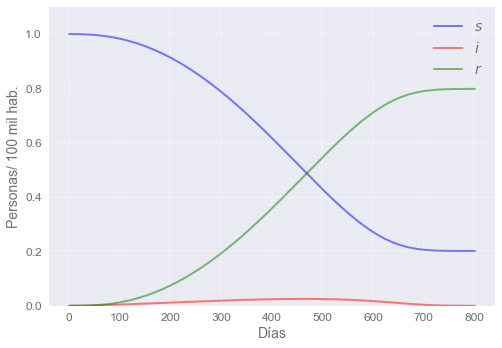

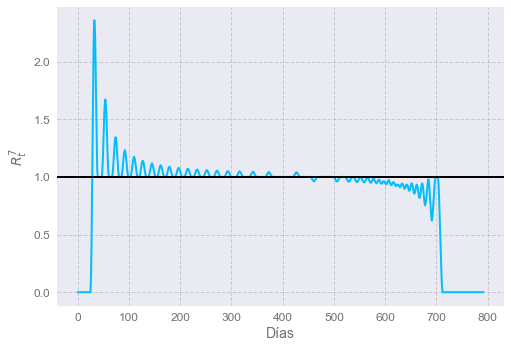

In [7]:
N = 10000.0
a_t, r_t_seven = solve_csir(0.15, 0.075,0.08*N,N,1/N,0.0,800.0,1.0)

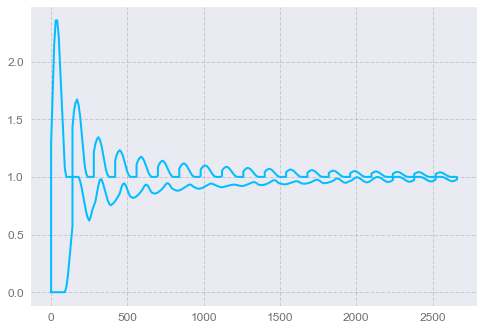

In [8]:
#make_diagram(a_t,r_t_seven)
plt.plot(a_t,r_t_seven)